In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import grad, jit, jacobian, vmap

import scipy.linalg as sl
import scipy.integrate as si
import scipy.optimize
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import time

In [2]:
import numpy as np

In [3]:
# our Fourier representation will use basis functions from n = -nmax to n = nmax
nmax = 16

# size of spatial domain
a = 16

In [4]:
# symmetric double well potential just for fun
def v(x):
    return 0.25*(x**2 - 25)**2

In [5]:
# some sampling and FFT tricks
# this integer '100' can be adjusted to improve resolution
# if we set f_sample = 2*nmax, then we are sampling at the Nyquist frequency
f_sample = 100 * 2 * nmax
t, dt = np.linspace(-a, a, f_sample+2, endpoint=False, retstep=True)
y = (np.fft.rfft(v(t)) / t.size)[:(2*nmax+1)]

# this stores the Fourier series coefficients for n-m=0 to n-m=2*nmax
vrow = y * (-1)**np.arange(2*nmax+1)

In [6]:
# create Toeplitz matrix
vmat = sl.toeplitz(r=vrow,c=np.conj(vrow))

# kinetic matrix
kmat = np.diag( np.arange(-nmax,nmax+1)**2 * np.pi**2 / (2*a**2) )

# Hamiltonian matrix 
hmat = kmat + vmat

# check whether Hamiltonian is Hermitian
print(np.linalg.norm( hmat - np.conj(hmat.T) ))

# eigendecomposition
spec, states = np.linalg.eigh(hmat)

# check whether this diagonalizes hmat
# note that if this is close to zero it means that
# hmat = states @ np.diag(spec) @ np.conj(states).T
np.linalg.norm( hmat @ states - states @ np.diag(spec) )

# check whether we have a unitary matrix
print(np.linalg.norm( states @ np.conj(states).T - np.eye(2*nmax+1) ))

0.0
6.7044174812213135e-15


In [7]:
# find indices that sort eigenvalues
ordering = np.argsort(spec)

# spatial grid for the purposes of plotting
xvec = np.linspace(-a, a, 1025)

# convert basis coefficients into wavefunction on grid by matrix multiplication
nvec = np.arange(-nmax,nmax+1)
convmat = np.exp(1j*np.pi*np.outer(nvec, xvec)/a)/np.sqrt(2*a)

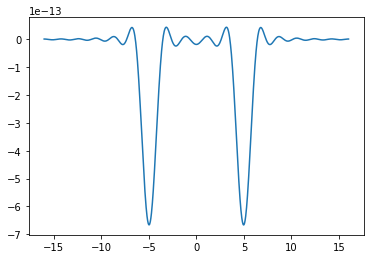

1.0


In [8]:
# pick out and plot ground state
groundstate = ordering[0]
wavefn = states[:,groundstate] @ convmat
plt.plot(xvec, -np.real(wavefn))
plt.show()

# check normalization
print(np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])))

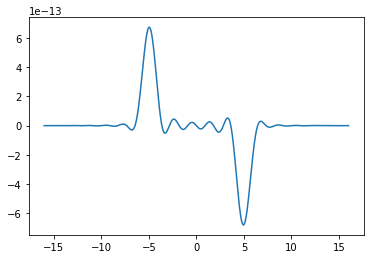

1.000000047158553


In [9]:
# pick out and plot j-th state with j starting at 0
wavefn = states[:,ordering[1]] @ convmat
plt.plot(xvec, np.imag(wavefn))
plt.show()

# check normalization
print(np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])))

In [10]:
# rounded box function
def psi0(x):
    return (1.0 + np.tanh((1 - x**2)/0.5))/2.58046

vraw = np.zeros(nmax+1, dtype=np.complex128)
for thisn in range(nmax+1):
    def integ(x):
        return (2*a)**(-0.5)*np.exp(-1j*np.pi*thisn*x/a)*psi0(x)
    def rinteg(x):
        return np.real(integ(x))
    def iinteg(x):
        return np.imag(integ(x))
    vraw[thisn] = si.quad(rinteg, a=-a, b=a)[0] + 1j*si.quad(iinteg, a=-a, b=a)[0]

ainit = np.concatenate([np.conjugate(np.flipud(vraw[1:])), vraw])

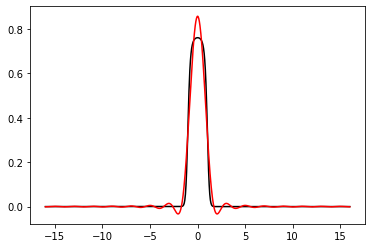

In [11]:
# just check whether psi0 is represented OK
plt.plot(xvec, psi0(xvec), color='black')
psi0recon = np.real(ainit @ convmat)
plt.plot(xvec, psi0recon, color='red')
plt.show()

In [12]:
# set the time step and compute the propagator matrix
# note that we are reusing the spec, states eigendecomposition of hmat computed above
dt = 0.01
prop = states @ np.diag(np.exp(-1j*spec*dt)) @ np.conj(states.T)

In [13]:
# propagate the "a" vector of coefficients as defined above
nsteps = 200
amat = np.zeros((nsteps+1, 2*nmax+1), dtype=np.complex128)
amat[0,:] = np.copy(ainit)
for j in range(nsteps):
    amat[j+1,:] = prop @ amat[j,:]

# compute the wave function in space from each "a" vector
# do it all at once using matrix multiplication!
psi2 = (np.abs(amat @ convmat))**2

In [14]:
Xind, Yind = np.meshgrid(np.arange(2*(2*nmax+1)-1),np.arange(2*(2*nmax+1)-1))
indices = np.stack([Xind.flatten(), Yind.flatten()]).T
print(indices.shape)

(4225, 2)


In [15]:
# this function implements the adjoint method described mathematically above
# it takes as input x, which is a concatenation of the real and imaginary parts of thetahat
# as you can see from the first 5 lines of the function, 
# the real and imaginary part of thetahat *parameterize* the potential matrix "vhatmat"
def toeplitz(r, c):
    c = np.asarray(c).ravel()
    r = np.asarray(r).ravel()
    # Form a 1-D array containing a reversed c followed by r[1:] that could be
    # strided to give us toeplitz matrix.
    vals = np.concatenate((c[::-1], r[1:]))
    out_shp = len(c), len(r)
    n = vals.strides[0]
    return np.lib.stride_tricks.as_strided(vals[len(c)-1:], shape=out_shp, strides=(-n, n)).copy()


In [16]:
toeplitz(np.array([1.0,3.0,-3.0]),np.array([1.0,4.0,-7.0]))

array([[ 1.,  3., -3.],
       [ 4.,  1.,  3.],
       [-7.,  4.,  1.]])

In [17]:
m = 2*nmax+1
n = 2*nmax+1
a = np.array((-1)*np.arange(0,m)).reshape(m,1) 
b = np.array([np.arange(m-1,m+n-1 ),])
indx = jnp.array(a + b)

def jaxtoeplitz(r, c):
    w = jnp.concatenate([jnp.flipud(c), r[1:]])
    Tw = w[indx]
    return Tw

In [18]:
# jaxtoeplitz(np.array([1.0,3.0,-3.0]),np.array([1.0,4.0,-7.0]))

# jtg = jacobian(jaxtoeplitz)
# jtg(np.array([1.0,3.0,-3.0]),np.array([1.0,4.0,-7.0]))

In [19]:
def adjhesshelper(x):
    m = 2*nmax + 1
    thetahatR = x[:m]
    thetahatI = jnp.concatenate([jnp.array([0.0]), x[m:]])
    thetahat = thetahatR + 1j*thetahatI
    vhatmat = jaxtoeplitz(r=thetahat,c=np.conj(thetahat))
    
    # Hamiltonian matrix 
    hhatmat = kmat + vhatmat
    
    # eigendecomposition and compute propagator
    hatspec, hatstates = jnp.linalg.eigh(hhatmat)
    hatprop = hatstates @ jnp.diag(jnp.exp(-1j*hatspec*dt)) @ jnp.conj(hatstates.T)
    hatpropH = hatstates @ jnp.diag(jnp.exp(1j*hatspec*dt)) @ jnp.conj(hatstates.T)
    
    # propagate the "a" vector of coefficients forward in time
    # in other words, solve the *forward* problem
    ahatmat = [jnp.array(ainit)]
    for j in range(nsteps):
        ahatmat.append( hatprop @ ahatmat[j] )
    
    ahatmat = jnp.stack(ahatmat)
    
    # propagate the "lambda" vector of coefficients backward in time
    # in other words, solve the *adjoint* problem
    lambmat = [ahatmat[nsteps,:] - amat[nsteps,:]]
    
    itr = 0
    for j in range(nsteps-1,-1,-1):
        lambmat.append( ahatmat[j,:] - amat[j,:] + hatpropH @ lambmat[itr] )
        itr += 1
        
    lambmat = jnp.flipud( jnp.stack(lambmat) )    
    
    # Compute the gradients
    # Most of this stuff is math that computes the directional derivative of the matrix exponential,
    # the part of the derivation above where we see "\partial \exp(Z) / \partial Z \cdot A"
    # for some matrix A.
    # All of this code has been checked against JAX autograd to make sure it is computing gradients correctly.
    # Note that it is much faster than JAX autograd.
    alldmat = np.zeros((2*m-1, m, m), dtype=np.complex128)
    expspec = np.exp(-1j*dt*hatspec)
    mask = np.zeros((m,m), dtype=jnp.complex128)
    for ii in range(m):
        for jj in range(m):
            if np.abs(hatspec[ii] - hatspec[jj]) < 1e-8:
                mask[ii,ii] = expspec[ii]
            else:
                mask[ii,jj] = (expspec[ii] - expspec[jj])/(-1j*dt*(hatspec[ii]-hatspec[jj]))
    
    derivamat = np.zeros((2*m-1, m, m), dtype=np.complex128)
    for iii in range(m):
        ctrvec = np.zeros(m, dtype=np.complex128)
        ctrvec[iii] = 1.0
        ctrmat = toeplitz(r=ctrvec, c=np.conj(ctrvec))
        derivamat[iii, :, :] = hatstates.conj().T @ ctrmat @ hatstates
        qmat = derivamat[iii, :, :] * mask
        alldmat[iii,:,:] = -1j*dt* hatstates @ qmat @ hatstates.conj().T
    
    for iii in range(m-1):
        ctrvec = np.zeros(m, dtype=np.complex128)
        ctrvec[iii + 1] = 1.0j
        ctrmat = toeplitz(r=ctrvec, c=np.conj(ctrvec))
        derivamat[m + iii, :, :] = hatstates.conj().T @ ctrmat @ hatstates
        qmat = derivamat[m + iii, :, :] * mask
        alldmat[m + iii,:,:] = -1j*dt* hatstates @ qmat @ hatstates.conj().T
    
    return lambmat, alldmat, ahatmat

In [28]:
def justobj(x):
    m = 2*nmax + 1
    thetahatR = x[:m]
    thetahatI = jnp.concatenate([jnp.array([0.0]), x[m:]])
    thetahat = thetahatR + 1j*thetahatI
    
    # hardcoded Toeplitz so that autodiff doesn't complain
    w = jnp.concatenate([jnp.flipud(jnp.conj(thetahat)), thetahat[1:]])
    vhatmat = w[indx]
    
    # Hamiltonian matrix 
    hhatmat = kmat + vhatmat
    
    # eigendecomposition and compute propagator
    hatspec, hatstates = jnp.linalg.eigh(hhatmat)
    hatprop = hatstates @ jnp.diag(jnp.exp(-1j*hatspec*dt)) @ jnp.conj(hatstates.T)
    hatpropH = hatstates @ jnp.diag(jnp.exp(1j*hatspec*dt)) @ jnp.conj(hatstates.T)
    
    # propagate the "a" vector of coefficients as defined above
    ahatmat = [jnp.array(ainit)]
    for j in range(nsteps):
        ahatmat.append( hatprop @ ahatmat[j] )
    
    ahatmat = jnp.stack(ahatmat)
    
    # compute only the objective function
    resid = ahatmat - amat
    obj = 0.5*jnp.real(jnp.sum(jnp.conj(resid)*resid))
    
    return obj

def justgrad(x):
    lambmat, alldmat, ahatmat = adjhesshelper(x)    
    # compute all entries of the gradient at once
    gradients = jnp.real(jnp.einsum('ij,ajk,ik->a', jnp.conj(lambmat[1:,:]), alldmat, ahatmat[:-1,:]))
    return gradients

In [21]:
truethetaR = jnp.real(vrow)
truethetaI = jnp.imag(vrow[1:])
x0 = jnp.concatenate([truethetaR, truethetaI])
print(x0.shape)

(65,)


In [29]:
justobj(x0)

DeviceArray(3.60239945e-23, dtype=float64)

In [23]:
mygrad = justgrad(x0)

In [30]:
jaxgrad = jit(grad(justobj))

In [31]:
jgrad = jaxgrad(x0)

In [32]:
np.linalg.norm(mygrad - jgrad)

4.489679952558946

In [27]:
randx = np.random.normal(size=4*nmax+1)*10
mygrad = justgrad(randx)
jgrad = jaxgrad(randx)
np.linalg.norm(mygrad - jgrad)

3.123502808682592e-12